In [ ]:
import requests
import pandas as pd
import numpy as np
import tweepy
import json

## Gathering 

**Gathering data image_predictions.tsv from online server.** <br>
**Gathering data tweet_json.txt from API** <br>
**Gathering data twitter-archive-enhanced.csv via download**


In [ ]:
# Download tsv from online server and open as pandas dataframe
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

with open ('image_predictions.tsv', mode = 'wb') as files:
    files.write(response.content)

In [ ]:
df_image = pd.read_csv('image_predictions.tsv', sep='\t')
image_clean = df_image.copy()

In [ ]:
df_archive = pd.read_csv('twitter-archive-enhanced.csv')
archive_clean = df_archive.copy()

In [ ]:
archive_clean.sample(5)

In [ ]:
tweet_id = list(df_archive.tweet_id)

In [ ]:
len(tweet_id)

In [ ]:
#Gather from Twitter's API using twitter ids

consumer_key = 'XXXX'
consumer_secret = 'XXXX'
access_token = 'XXXX'
access_secret = 'XXXX'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)

In [ ]:
#Get tweet JSON data via tweet ID using Tweepy and store them in tweet_json.txt

for ids in tweet_id:
    try:
        tweet = api.get_status(ids, tweet_mode='extended')
        with open('tweet_json.txt', 'a') as f:
            json.dump(tweet._json, f)
            f.write('\n')
    except tweepy.TweepError as e:
        print ids, e.reason

In [ ]:
#open the tweet_json.txt 
tweet_json = []
for line in open('tweet_json.txt', 'r'):
    tweet_json.append(json.loads(line))

In [ ]:
#tweet ID, retweet count, and favorite count
df_list = []
for item in tweet_json:
    df_list.append({'tweet_id': item['id'], 'retweet_count': item['retweet_count'], 'favorite_count': item['favorite_count']})

df_twitter_counts = pd.DataFrame(df_list, columns = ['tweet_id', 'retweet_count', 'favorite_count'])

In [ ]:
twitter_counts_clean = df_twitter_counts.copy()

## Assess

### df_image    
  1. Names in colume p1, p2 and p3 contain both upper and lower case. (quality)   

 
### df_archive
  1. in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id and retweeted_status_user_id are exponential adn mostly empty (quality) 
  2. The name column contains 'a' and 'an' and 'the' and some typos like 'Fr\xc3\xb6nq'and most of the names are none (quality) 
  3. Timestamp and retweeted_status_timestamp column is object (quality) 
  4. rating_numerator contains value that is as big as 75, 420 1776 (quality) 
  5. rating_denominator contains value that is bigger than 10 (quality) 
  6. The columns named doggo, floofer, pupper and puppo are mostly empty (tidiness) 
  7. df_tweet_counts is in a seperate table (tidiness) 
  8. The source column contains ’a herf‘ and ‘/a’ (quality)
  9. df_image contains 2075 lines which is less than that in the df_archive table (tidiness)
  10. The dog type contains two rows with multiple dog types (quality)

In [ ]:
image_clean.info()

In [ ]:
image_clean.sample(5)

In [ ]:
image_clean.info()

In [ ]:
archive_clean.sample(5)

In [ ]:
archive_clean.describe()

In [ ]:
archive_clean.source.value_counts()

In [ ]:
archive_clean[archive_clean['in_reply_to_status_id'].notnull()]

In [ ]:
archive_clean[archive_clean['retweeted_status_id'].notnull()]

In [ ]:
archive_clean['name'].value_counts()

In [ ]:
twitter_counts_clean.head()

In [ ]:
twitter_counts_clean.info()

In [ ]:
archive_clean.groupby('name').groups.keys()

In [ ]:
archive_clean.rating_numerator.value_counts()

In [ ]:
archive_clean.rating_denominator.value_counts()

In [ ]:
archive_clean[archive_clean['in_reply_to_status_id'].notnull()]

In [ ]:
print (sum(archive_clean.doggo != 'None'))
print (sum(archive_clean.floofer != 'None'))
print (sum(archive_clean.pupper!= 'None'))
print (sum(archive_clean.puppo != 'None'))

## Clean

   
### df_image    
  1. Names in colume p1, p2 and p3 are converted to lower case.    
  
 
### df_archive
  1. in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id and retweeted_status_user_id are removed.
  2. Extract the names from the text.
  3. Convert timestamp and retweeted_status_timestamp from object to timestamp.
  4. Remove entries of rating_numerator that is greater than 14 as most ratings are equal or less than 14
  5. Remove entries of rating_denominator that is greater than 10
  6. The columns named doggo, floofer, pupper and puppo are combined to one column and the orginal column is removed
  7. twitter_counts_clean is added to archive_clean
  8. The source column contains a herf and /a which needs to be parsed(The code is not provided becanuse I have not found a way to do this)
  9. df_image is added to the df_archive table
  10. The two rows with multiple dog types are removed.


**1. Names in colume p1, p2 and p3 are converted to lower case**

In [ ]:
#Names in colume p1, p2 and p3 are converted to lower case.
lower = ['p1', 'p2', 'p3']
for col in lower:
    image_clean[col] = image_clean[col].str.lower()

In [ ]:
#Test
image_clean.sample(5)

**in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id and retweeted_status_user_id are dropeed**

In [ ]:
to_drop = ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id']
for i in to_drop:
    archive_clean = archive_clean.drop(i, axis = 1)

In [ ]:
#test
archive_clean.columns

**Extract the names from the text.**

In [ ]:
archive_clean.name = archive_clean.text.str.extract('(?:This is|Meet|name is|Say hello to|named) ([A-Z][a-z]{2,12})', expand=False).values

In [ ]:
#Test
archive_clean.name.value_counts()

**Convert timestamp from object to timestamp.**

In [ ]:
archive_clean.timestamp = pd.to_datetime(archive_clean.timestamp)
archive_clean.retweeted_status_timestamp = pd.to_datetime(archive_clean.timestamp)

In [ ]:
#test
archive_clean.info()

**Remove entries of rating_numerator that is greater than 14 as most ratings are equal or less than 14**

In [ ]:
to_drop = archive_clean[archive_clean['rating_numerator'] > 14].index.values
to_drop

In [ ]:
archive_clean = archive_clean.drop(to_drop, axis = 0)

In [ ]:
#test
archive_clean[archive_clean['rating_denominator'] > 14]

**Reomove the rating_denominator that is bigger than 10**

In [ ]:
to_drop = archive_clean[archive_clean['rating_denominator'] > 10].index.values
to_drop

In [ ]:
archive_clean = archive_clean.drop(to_drop, axis = 0)

In [ ]:
#test
archive_clean[archive_clean['rating_denominator'] > 10]

In [ ]:
archive_clean.rating_denominator.value_counts()

In [ ]:
archive_clean.rating_numerator.dtype

  **6. The columns named doggo, floofer, pupper and puppo are combined to one column.**

In [ ]:
to_move = ['doggo', 'floofer', 'pupper', 'puppo']
for i in to_move:
    archive_clean[i].replace('None', np.nan, inplace=True)

In [ ]:
archive_clean['type'] = archive_clean[to_move].apply(lambda x: ','.join(x.dropna()), axis=1)

In [ ]:
to_move = ['doggo', 'floofer', 'pupper', 'puppo']
for i in to_move:
    archive_clean.drop(i, axis = 1, inplace = True)

In [ ]:
#test
archive_clean.columns

**7. twitter_counts_clean is added to archive_clean**

In [ ]:
archive_clean = pd.merge(archive_clean, twitter_counts_clean, on = 'tweet_id', how = 'left')

In [ ]:
archive_clean.retweet_count = archive_clean.retweet_count.fillna(0)
archive_clean.favorite_count = archive_clean.favorite_count.fillna(0)

In [ ]:
archive_clean.retweet_count = archive_clean.retweet_count.astype(int)
archive_clean.favorite_count = archive_clean.favorite_count.astype(int)

In [ ]:
#test
archive_clean.info()

**9. df_image is added to the df_archive table **

In [ ]:
archive_clean = pd.merge(archive_clean, image_clean, on = 'tweet_id', how = 'left')

In [ ]:
#test
archive_clean.info()

**10. The empty entry in dog type column is converted to null. The entries that contain two dop types are converted to 1 by extracting the first one**

In [64]:
archive_clean.replace('', np.nan, regex=True, inplace = True)

In [86]:
archive_clean['type'] = archive_clean['type'].str.split(',', expand=True)[0]

In [94]:
#test
archive_clean.type.value_counts()

pupper     244
doggo      97 
puppo      29 
floofer    9  
Name: type, dtype: int64

## Analysis

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## What is the distribution of the rating_numerator.

**The rating_numerator is analyzed to find out the distribution of the ratings. The rating_numerator is grouped by in different values and the total number of ratings of each value is counted. It’s found that the distribution is left skewed with a rating of 12 reaching the maximum. There are also some ratings that are below 10 with the minimum rating being 0. The number of people is in a positive correlation with the rating value from 0-10. Most of the ratings fall in the range of 10-13. Going from 13 to 14, the number of ratings drastically decrease**


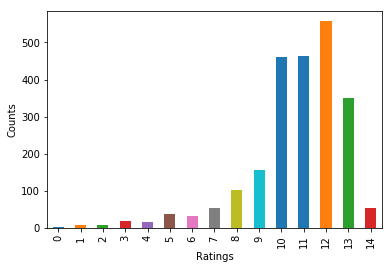

In [93]:
#plot the bar plot of how many tweets there are for each ratings
archive_clean.groupby('rating_numerator').size().plot(kind='bar')
plt.xlabel('Ratings')
plt.ylabel('Counts')
plt.savefig('rating_distribution.jpg');

## How is the number of favorites related to the ratings. 

**The mean value of favorites in each rating group (0-14) is analyzed with a bar plot. The rating group of 1-10 has very close number of favorites. Surprisingly, the group with a rating of 0 is noticeably high in number of favorites compared with rating group (1-10). Going from rating group 9 to 14, an increase in the number of favorites is observed, indicating a positive correlation. The rating group that has the highest number of favorites is 14.**

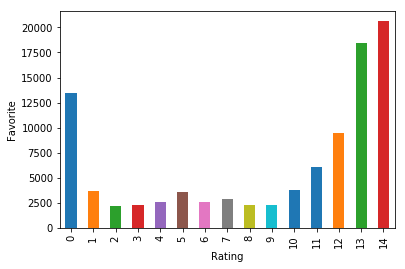

In [91]:
archive_clean.groupby('rating_numerator').favorite_count.mean().plot(kind = 'bar')
plt.xlabel('Rating')
plt.ylabel('Favorite');

## How is the number of retweets related to the ratings.

**The mean value of number of time retweeted in each rating group (0-14) is analyzed with a bar plot. This plot is very similar in shape with the previous one (favorites number vs ratings) except that group with a rating of 0 is not as high. All together the number of retweets in rating group 0-10 are quite close. There’s a dramatic increase in the number of retweets as the ratings go beyond 10, reaching maximum with rating value of 14.**

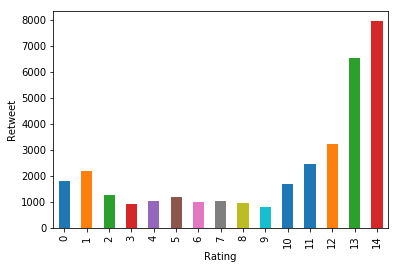

In [89]:
archive_clean.groupby('rating_numerator').retweet_count.mean().plot(kind = 'bar')
plt.xlabel('Rating')
plt.ylabel('Retweet');

In [ ]:
archive_clean.plot.scatter('retweet_count','favorite_count')
plt.xlabel('Retweets')
plt.ylabel('Favorite');

In [95]:
archive_clean.to_csv('twitter_archive_master.csv', index=False)